In [1]:
from prefect import task
import pandas as pd

In [2]:
@task
def extract():
    #returns data set to pass through pipeline
    return [1, 2, 3]

@task
def transform(data):
    '''Apply transformation to data'''
    return[i * 10 for i in data]

@task
def load(data):
    '''Print the data to indicate it was received'''
    print(f'Here is the data you requested: {data}')

In [3]:
from prefect import Flow

In [4]:
with Flow('ETL') as flow:
    e = extract()
    t = transform(e)
    l = load(t)
    
flow.run()

[2019-10-24 20:03:56,834] INFO - prefect.FlowRunner | Beginning Flow run for 'ETL'
[2019-10-24 20:03:56,838] INFO - prefect.FlowRunner | Starting flow run.
[2019-10-24 20:03:56,845] INFO - prefect.TaskRunner | Task 'extract': Starting task run...
[2019-10-24 20:03:56,848] INFO - prefect.TaskRunner | Task 'extract': finished task run for task with final state: 'Success'
[2019-10-24 20:03:56,855] INFO - prefect.TaskRunner | Task 'transform': Starting task run...
[2019-10-24 20:03:56,859] INFO - prefect.TaskRunner | Task 'transform': finished task run for task with final state: 'Success'
[2019-10-24 20:03:56,866] INFO - prefect.TaskRunner | Task 'load': Starting task run...
[2019-10-24 20:03:56,871] INFO - prefect.TaskRunner | Task 'load': finished task run for task with final state: 'Success'
[2019-10-24 20:03:56,872] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded


Here is the data you requested: [10, 20, 30]


<Success: "All reference tasks succeeded.">

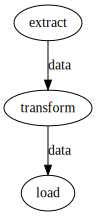

In [6]:
flow.visualize()